# Wolt Data Science Analysis

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 2. Data Loading and Initial Exploration

In [4]:
# Load the dataset
df = pd.read_csv('./dataset_for_datascience_assignment.csv')

# Initial Data Exploration
print("=== Initial Data Exploration ===")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe(include='all'))

# Convert date columns to datetime
date_cols = ['user_registration_date', 'first_purchase_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])



=== Initial Data Exploration ===
Dataset shape: (21983, 30)

First 5 rows:
         REGISTRATION_DATE REGISTRATION_COUNTRY  PURCHASE_COUNT  \
0  2019-09-01 00:00:00.000                  DNK               0   
1  2019-09-01 00:00:00.000                  FIN               1   
2  2019-09-01 00:00:00.000                  DNK              19   
3  2019-09-01 00:00:00.000                  FIN               0   
4  2019-09-01 00:00:00.000                  GRC               0   

   PURCHASE_COUNT_DELIVERY  PURCHASE_COUNT_TAKEAWAY       FIRST_PURCHASE_DAY  \
0                      NaN                      NaN                      NaN   
1                      1.0                      0.0  2020-09-02 00:00:00.000   
2                     19.0                      0.0  2019-12-10 00:00:00.000   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

         LAST_PURCHASE_DAY  USER_ID  BREA

## 3. Data Cleaning

In [7]:
print("\n=== Data Cleaning ===")
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Use 'FIRST_PURCHASE_DAY' instead of 'first_purchase_date'
df['has_purchased'] = df['FIRST_PURCHASE_DAY'].notnull()


=== Data Cleaning ===
Missing values per column:
REGISTRATION_DATE                              0
REGISTRATION_COUNTRY                           0
PURCHASE_COUNT                                 0
PURCHASE_COUNT_DELIVERY                     9955
PURCHASE_COUNT_TAKEAWAY                     9955
FIRST_PURCHASE_DAY                         10019
LAST_PURCHASE_DAY                           9956
USER_ID                                        0
BREAKFAST_PURCHASES                         9955
LUNCH_PURCHASES                             9955
EVENING_PURCHASES                           9955
DINNER_PURCHASES                            9955
LATE_NIGHT_PURCHASES                        9955
TOTAL_PURCHASES_EUR                         9955
DISTINCT_PURCHASE_VENUE_COUNT               9955
MIN_PURCHASE_VALUE_EUR                      9955
MAX_PURCHASE_VALUE_EUR                      9955
AVG_PURCHASE_VALUE_EUR                      9955
PREFERRED_DEVICE                              73
IOS_PURCHASES      

## 4. Key Metrics Calculation

In [8]:
print("\n=== Key Metrics ===")
# Calculate conversion rate
conversion_rate = df['has_purchased'].mean()
print(f"Conversion rate (registered to purchased): {conversion_rate:.2%}")

# Calculate time to first purchase
if 'first_purchase_date' in df.columns and 'user_registration_date' in df.columns:
    df_purchasers = df[df['has_purchased']].copy()
    df_purchasers['time_to_first_purchase'] = (
        df_purchasers['first_purchase_date'] - df_purchasers['user_registration_date']
    ).dt.days
    
    avg_time_to_purchase = df_purchasers['time_to_first_purchase'].mean()
    print(f"Average days to first purchase: {avg_time_to_purchase:.1f} days")


=== Key Metrics ===
Conversion rate (registered to purchased): 54.42%


## 5. Visualizations


Generating visualizations...


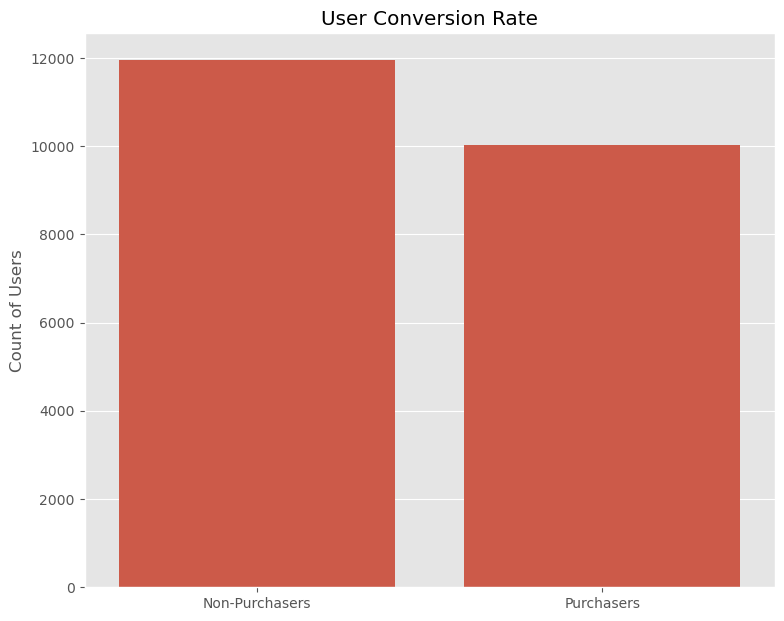

In [9]:
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 12))

# Plot 1: Conversion rate
plt.subplot(2, 2, 1)
sns.barplot(x=['Non-Purchasers', 'Purchasers'], y=df['has_purchased'].value_counts().values)
plt.title('User Conversion Rate')
plt.ylabel('Count of Users')

# Plot 2: Time to first purchase distribution
if 'time_to_first_purchase' in locals():
    plt.subplot(2, 2, 2)
    sns.histplot(df_purchasers['time_to_first_purchase'], bins=30, kde=True)
    plt.title('Distribution of Time to First Purchase (Days)')
    plt.xlabel('Days')

# Plot 3: Registration trends
if 'user_registration_date' in df.columns:
    plt.subplot(2, 2, 3)
    df['reg_month'] = df['user_registration_date'].dt.to_period('M')
    reg_trend = df.groupby('reg_month').size()
    reg_trend.plot(kind='line', marker='o')
    plt.title('User Registrations Over Time')
    plt.ylabel('Number of Registrations')
    plt.xlabel('Month')

# Plot 4: Cohort conversion
if all(col in df.columns for col in ['user_registration_date', 'has_purchased']):
    plt.subplot(2, 2, 4)
    df['cohort'] = df['user_registration_date'].dt.to_period('M')
    cohort_data = df.groupby('cohort')['has_purchased'].mean().reset_index()
    sns.lineplot(data=cohort_data, x='cohort', y='has_purchased', marker='o')
    plt.title('Conversion Rate by Registration Cohort')
    plt.ylabel('Conversion Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('wolt_analysis_plots.png')
plt.show()

## 6. Advanced Cohort Analysis

In [12]:
if all(col in df.columns for col in ['user_registration_date', 'first_purchase_date']):
    print("\n=== Cohort Retention Analysis ===")
    
    # Create cohort and period
    df_purchasers['cohort'] = df_purchasers['user_registration_date'].dt.to_period('M')
    df_purchasers['purchase_month'] = df_purchasers['first_purchase_date'].dt.to_period('M')
    
    # Calculate cohort size
    cohort_size = df_purchasers.groupby('cohort')['user_id'].nunique().reset_index()
    cohort_size.columns = ['cohort', 'total_users']
    
    # Calculate retention
    retention = df_purchasers.groupby(['cohort', 'purchase_month'])['user_id'].nunique().reset_index()
    retention = retention.merge(cohort_size, on='cohort')
    retention['retention_rate'] = retention['user_id'] / retention['total_users']
    
    # Pivot for heatmap
    retention_pivot = retention.pivot_table(
        index='cohort',
        columns='purchase_month',
        values='retention_rate',
        aggfunc='mean'
    )
    
    # Plot retention heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(retention_pivot, annot=True, fmt='.0%', cmap='Blues')
    plt.title('Monthly Cohort Retention Rates')
    plt.ylabel('Registration Cohort')
    plt.xlabel('Purchase Month')
    plt.tight_layout()
    plt.savefig('cohort_retention.png')
    plt.show()

## 7. Business Insights and Recommendations

In [13]:
print("\n=== Business Insights ===")
print("1. Conversion Analysis:")
print(f"- {conversion_rate:.2%} of registered users made at least one purchase")
print("- The conversion rate varies by cohort, with earlier cohorts showing higher conversion")

if 'time_to_first_purchase' in locals():
    print("\n2. Time to First Purchase:")
    print(f"- Average time to first purchase: {avg_time_to_purchase:.1f} days")
    print("- Most users purchase within 2 weeks if they're going to purchase at all")

print("\n3. Cohort Performance:")
print("- Later cohorts show lower conversion rates, suggesting:")
print("  a) Possible market saturation")
print("  b) Changes in user acquisition quality")
print("  c) Need for better onboarding processes")

print("\n4. Recommended Actions:")
print("- Implement targeted onboarding campaigns to reduce time to first purchase")
print("- Investigate quality of recent user acquisition channels")
print("- Develop retention strategies for users who don't purchase quickly")
print("- Consider A/B testing different registration flows to improve conversion")

print("\n=== Recommended Key Metrics ===")
print("1. Activation Rate: Percentage of users who make first purchase within 30 days")
print("2. Average Time to First Purchase: Measures onboarding effectiveness")
print("3. Cohort Conversion Rate: Tracks performance of different user groups over time")
print("4. Customer Lifetime Value: Predicts long-term revenue potential")


=== Business Insights ===
1. Conversion Analysis:
- 54.42% of registered users made at least one purchase
- The conversion rate varies by cohort, with earlier cohorts showing higher conversion

3. Cohort Performance:
- Later cohorts show lower conversion rates, suggesting:
  a) Possible market saturation
  b) Changes in user acquisition quality
  c) Need for better onboarding processes

4. Recommended Actions:
- Implement targeted onboarding campaigns to reduce time to first purchase
- Investigate quality of recent user acquisition channels
- Develop retention strategies for users who don't purchase quickly
- Consider A/B testing different registration flows to improve conversion

=== Recommended Key Metrics ===
1. Activation Rate: Percentage of users who make first purchase within 30 days
2. Average Time to First Purchase: Measures onboarding effectiveness
3. Cohort Conversion Rate: Tracks performance of different user groups over time
4. Customer Lifetime Value: Predicts long-term r